In [1]:
%matplotlib inline

# Train_small
## Goal: train on 100 examples and achieve 100% accuracy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

## Here we create a customized data loader for the CVPR dataset 

In [32]:
class CVPR(Dataset):
    """
    A customized data loader for CVPR.
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False):
        """ Intialize the CVPR dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        filenames = glob.glob(osp.join(root, '*.jpg'))
        for fn in filenames:
            lbl = fn[:-4] + '_instanceIds.png'
            lbl = lbl.replace('color', 'label')
            self.filenames.append((fn, lbl)) # (filename, label) pair
            if len(self.filenames) >= 100: 
                break
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            # load labels
            image = Image.open(label)
            # avoid too many opened files bug
            self.labels.append(image.copy())
            image.close()

    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            label = Image.open(label)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
            label = self.transform(label)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [33]:
# Create the CVPR dataset. 
# transforms.ToTensor() automatically converts PIL images to
# torch tensors with range [0, 1]

trainset = CVPR(
    root='../data/cvpr-2018-autonomous-driving/train_color',
    preload=False, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=1)

# # load the testset
# testset = CVPR(
#     root='mnist_png/testing',
#     preload=True, transform=transforms.ToTensor(),
# )
# # Use the torch dataloader to iterate through the dataset
# testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [34]:
print(len(trainset))
print(trainset[0])
print(trainset[0][0].shape)

100
(tensor([[[ 0.0824,  0.0863,  0.0902,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0863,  0.0902,  0.0902,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0863,  0.0863,  0.0863,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.2078,  0.2039,  0.2000,  ...,  0.2549,  0.2588,  0.2588],
         [ 0.2078,  0.2078,  0.2157,  ...,  0.2627,  0.2588,  0.2588],
         [ 0.2078,  0.2118,  0.2235,  ...,  0.2824,  0.2745,  0.2706]],

        [[ 0.0863,  0.0902,  0.0941,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0902,  0.0941,  0.0941,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0902,  0.0902,  0.0902,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.2353,  0.2314,  0.2275,  ...,  0.2941,  0.2980,  0.2980],
         [ 0.2353,  0.2353,  0.2314,  ...,  0.3098,  0.3059,  0.3059],
         [ 0.2353,  0.2392,  0.2392,  ...,  0.3294,  0.3294,  0.3255]],

        [[ 0.1020,  0.1059,  0.1137,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.1098,  0.1137,  0.1137,  ..

## The commented out section using the data iterator does not work because the labels are of class PIL.Image and the iterator expects tensors/numbers/dicts
## Do we want to keep labels as PIL.Images or store them as np.arrays/other?

<class 'torch.Tensor'>


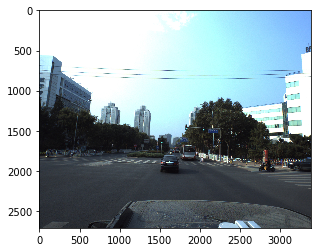

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# image, label = trainset[5]

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()
print(type(labels))
# show images
imshow(torchvision.utils.make_grid(images))
# show labels
imshow(torchvision.utils.make_grid(images))

### Each image is represented as a PyTorch Tensor. 

torch.Size([3, 2710, 3384])


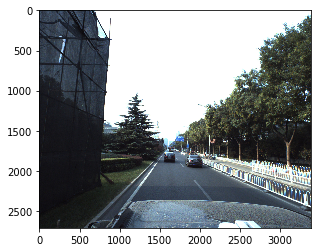

In [26]:
print(image.shape)
imshow(image)

### The labels are PIL Images in grayscale (each Image is a 2D matrix with 32bit values corresponding to grayscale colors). See below for ways to manipulate the labels.

In [27]:
# Can use PIL Image class methods (https://pillow.readthedocs.io/en/3.1.x/reference/Image.html)
print('Mode is', label.mode)
print('Size is', label.size)
print()

# Can convert to np array using np.asarray function
pixels = np.asarray(label)
print(pixels)

Mode is I
Size is (3384, 2710)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


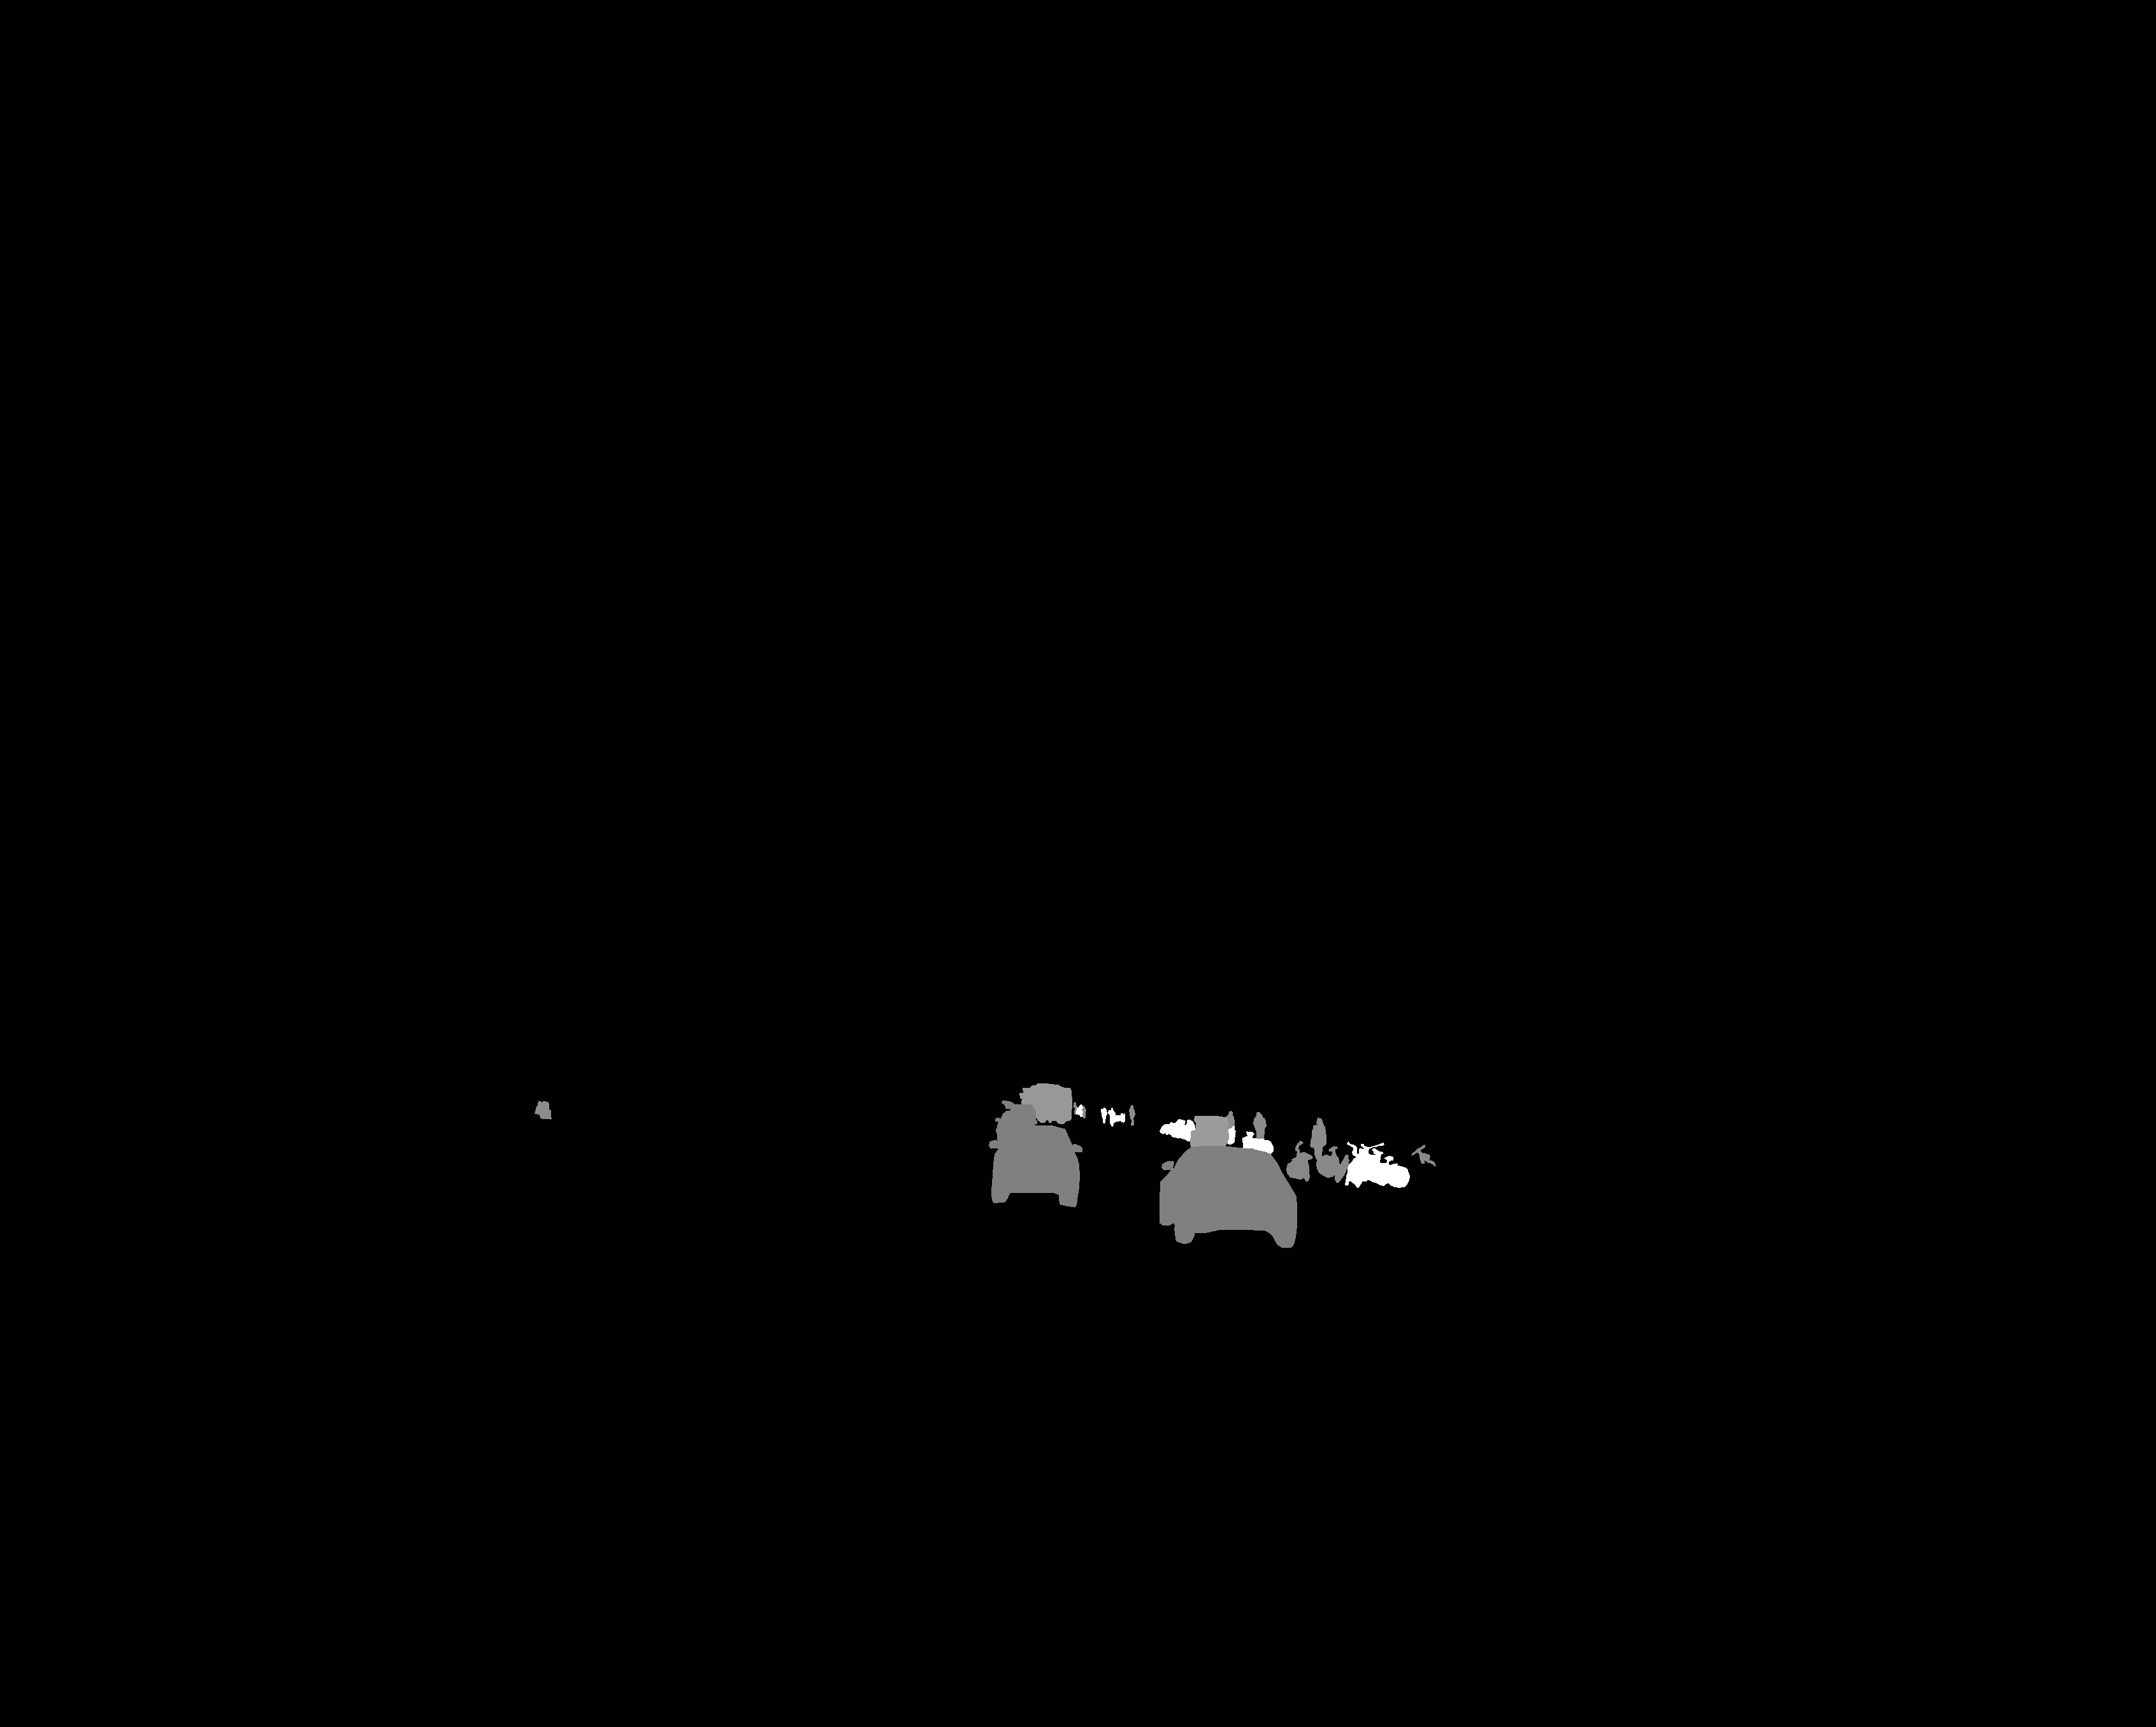

In [28]:
label

# TODO: Set up network and start training.
# Ask TA's about using DataLoader w/ PIL.Images
Look at the notebook pytorch_tutorial for starter code.

In [36]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device(cuda if use_cuda else "cpu")
print(device)

cpu


In [37]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(trainset_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

In [38]:
model = None
optimizer = None
learning_rate = 1e-2
in_channel = 3
channel_1 = 48
channel_2 = 48
channel_3 = 16
hidden_1 = 100
hidden_2 = 50
conv1 = nn.Conv2d(in_channel, channel_1, (5,5), padding=2, bias=True)
conv2 = nn.Conv2d(channel_1, channel_2, (3,3), padding=1, bias=True)
conv3 = nn.Conv2d(channel_2, channel_3, (3,3), padding=1, bias=True)
model = nn.Sequential(
    conv1,
    nn.ReLU(),
    nn.MaxPool2d(3, stride=2),
    nn.BatchNorm2d(channel_1),
    conv2,
    nn.ReLU(),
    nn.MaxPool2d(3, stride=2),
    nn.BatchNorm2d(channel_2),
    conv3,
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.BatchNorm2d(channel_3),
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.Upsample(scale_factor=2, mode='bilinear'), 
    
)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
train_part34(model, optimizer, epochs=10)

NameError: name 'dtype' is not defined